In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import fftpack
from sklearn.preprocessing import StandardScaler
from scipy.optimize import curve_fit
from tqdm import tqdm
from scipy.optimize import differential_evolution

RSEED=42

In [15]:
df = pd.read_csv('data/train.csv')

In [137]:
df.query('breath_id==8')

,id,breath_id,R,C,time_step,u_in,u_out,pressure


In [5]:
new_feats=pd.read_csv('utms.csv')

In [6]:
df = df.merge(new_feats, on='id')

In [7]:
# Feature 
df['vol'] = df['time_step'] * df['u_in']
df['vol'] = df.query('u_out==0').groupby('breath_id')['vol'].cumsum()
df['rtime']=df['time_step'].apply(lambda x: round(x,3))
df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
df['minus_one']=-1.0
df['plus_one']=1.0
df['exponent']=(df['minus_one']*df['time_step'])/(df['R']*df['C'])
df['factor']=np.exp(df['exponent'])
df['vf']=(df['u_in_cumsum']*df['R'])/df['factor']
df['vt']=0
df.loc[df['time_step'] != 0, 'vt']=df['vol']/(df['C']*(df['minus_one']*df['factor']+df['plus_one']))
df['v']=df['vf']+df['vt']
df['step_id']=df.id.apply(lambda x: x%80)

#df=df.query('u_out==0')
df=df.drop(['minus_one', 'plus_one', 'exponent', 'factor', 'step_id', 'u_out'], axis=1)

#cols=['v','u_in_cumsum','vol','pressure', 'u_in', 'R', 'C', 'time_step',"step_id"]
#red_df=df[cols]
#red_df=pd.get_dummies(data=df, columns=['R','C', 'step_id'],drop_first=True)

In [141]:
df.breath_id.nunique()

75450

In [153]:
def objective_loop(x,a,b):
    return a*x+b

def objective(x,a,b,c,d,e,f,g,h):
    #return (-c+a*np.sin(h*x**2))*(e+f*np.sin((50*d*np.pi*x)/(b)))+g
    #return (-a+b*np.sin(c*x**2+d))*(e+f*np.sin(g*x+h))+j
    return a*np.exp(b*x)*np.sin(c*x+d) + e*np.sin(f*x+g) + h
    #return a*x*np.heaviside(x-b)+c*x*np.heaviside(x-d)

def objective_CK(x,a,b,c,d,e,f,g,h,j):
    #return (-c+a*np.sin(h*x**2))*(e+f*np.sin((50*d*np.pi*x)/(b)))+g
    return (-a+b*np.sin(c*x**2+d))*(e+f*np.sin(g*x+h))+j


# create empty df for appending
df_test=df[['u_in', 'time_step', 'breath_id']]
bad_list = []
array_sub=df_test.breath_id.unique()

#for i in tqdm(range(len(array_sub))):
for i in tqdm(range(0,1000)):
    try:
        #############################
        ####  u_in curve fitting ####
        #############################
        
        breath = df_test[df_test['breath_id']==array_sub[i]][['time_step', 'u_in']]
        #print(breath.head())
        #df_temp=df_test.query('breath_id==b_ind') # <- pull out single breaths from df (full data) or query for smaller subset

        #y_train=breath.u_in
        #x_train=breath.time_step
        #print(x_train, y_train)

        popt, _ = curve_fit(objective, breath.time_step, breath.u_in, p0=[ 12.752477  ,  -0.67085112,   5.41190447,  -0.48596679, 3.86219028, -10.43610426,   8.54696684,  26.1692981 ])
        #a,b,c,d,e,f,g,h,j = popt
        #print(a,b,c,d,e,f,g,h) # to print all the 

        #x_test=np.array(np.linspace(0,1,len(y_train)))
        #y_pred = objective(x_test,a,b,c,d,e,f,g,h)
        #mae1=mean_absolute_error(y_train, y_pred).round(3)

        # for plotting
        # plt.plot(x_train,y_train,c="blue",label="true")
        #plt.plot(x_test,y_pred,c="red",label="predicted")
        #plt.legend()
        #print("MAE: ",mean_absolute_error(y_train, y_pred).round(3))

        ########################################################
        ####  seasonality decomposition/period optimization ####
        ########################################################
        #mae_list=[]
        #a_list=[]
        #b_list=[]
        #for j in range(1,15): #loop to find period with most linear trend (according to MAE score)
        #    seas=seasonal_decompose(x=df_temp.u_in+1,model="multiplicative",period=j, two_sided=True)
        #    tren=seas.trend.dropna()
        #    x_train=tren.index.to_list()
        #    y_train=tren.to_list()

        #    popt, _ = curve_fit(objective_loop, x_train, y_train)
        #    k,l = popt
        #    x_test=np.array(np.linspace(min(x_train),max(x_train),len(y_train)))
        #    y_pred = objective_loop(x_test,k,l)
        #    mae_list.append(mean_absolute_error(y_train, y_pred).round(3))
        #    a_list.append(k)
        #    b_list.append(l)
        #df_test.loc[len(df_test)] = [a,b,c,d,e,f,g,h,ii,mae1,np.min(mae_list),np.argmin(mae_list)+1,a_list[np.argmin(mae_list)],b_list[np.argmin(mae_list)]]
    except Exception:
        bad_list.append(i)
        #break

100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


In [154]:
print(len(bad_list), df.breath_id.nunique())

438 75450


In [155]:
bad_list[:5]

[1, 6, 8, 9, 10]

In [ ]:
def objective(x,a,b,c,d,e,f,g,h):
    #return (-c+a*np.sin(h*x**2))*(e+f*np.sin((50*d*np.pi*x)/(b)))+g
    #return (-a+b*np.sin(c*x**2+d))*(e+f*np.sin(g*x+h))+j
    return a*np.exp(b*x)*np.sin(c*x+d) + e*np.sin(f*x+g) + h

In [161]:
b1=df.query('breath_id==2')[['u_in', 'time_step']]
popt, _ = curve_fit(objective, b1.time_step, b1.u_in, maxfev=5000)#, p0=[ 12.752477  ,  -0.67085112,   5.41190447,  -0.48596679, 3.86219028, -10.43610426,   8.54696684,  26.1692981 ])

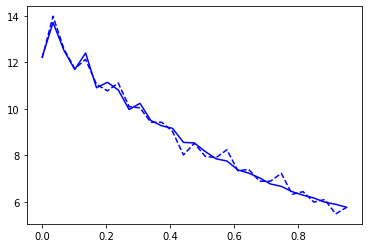

In [162]:
fig=plt.figure()
plt.plot(b1.time_step, objective(b1.time_step, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6], popt[7]), 'b')
plt.plot(b1.time_step,b1.u_in,'b--')

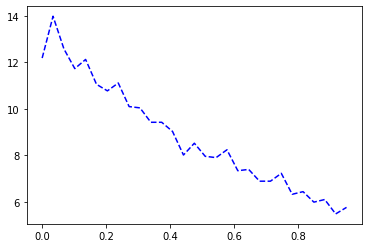

In [184]:
b1=df.query('breath_id==2')[['u_in', 'time_step']]

fig=plt.figure()
#plt.plot(b1.time_step, objective(b1.time_step, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6], popt[7]), 'b')
plt.plot(b1.time_step,b1.u_in,'b--')

In [166]:
def objective_cube(params):
    a,b,c,d,e,f,g,h = params
    return a*np.exp(b*b1.u_in)*np.sin(c*b1.u_in+d) + e*np.sin(f*b1.u_in+g) + h

In [167]:
bounds = [(0,20), (0, 2), (0, 2), (0, np.pi), (0, 2), (0,2), (0,np.pi), (0,2)]
result = differential_evolution(objective_cube, bounds)

RuntimeError: func(x, *args) must return a scalar value

In [165]:
def ackley(x):
     arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))
     arg2 = 0.5 * (np.cos(2. * np.pi * x[0]) + np.cos(2. * np.pi * x[1]))
     return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e
bounds = [(-5, 5), (-5, 5)]
result = differential_evolution(ackley, bounds)
result.x, result.fun

(array([0., 0.]), 4.440892098500626e-16)

In [ ]:
for p_set in pgrid:
    try:
        bla
    except Exception:
        blub

In [178]:
v1=5

for i in range(6):
    try:
        v1==i
    except:
        print('bla')

In [251]:
def objective_loop(x,a,b):
    return a*x+b

def objective(x,a,b,c,d,e,f,g,h):
    #return (-c+a*np.sin(h*x**2))*(e+f*np.sin((50*d*np.pi*x)/(b)))+g
    #return (-a+b*np.sin(c*x**2+d))*(e+f*np.sin(g*x+h))+j
    return a*np.exp(b*x)*np.sin(c*x+d) + e*np.sin(f*x+g) + h


# create empty df for appending
df_test=df[['u_in', 'time_step', 'breath_id']]
bad_list = []
array_sub=df_test.breath_id.unique()

param_grid=[]
param_grid.append([ 12.752477  ,  -0.67085112, 5.41190447,  -0.48596679, 3.86219028, -10.43610426,   8.54696684,  26.1692981 ])
param_grid.append([1., 1., 1., 1., 1., 1., 1., 1.])
param_grid.append([ 1.58058048e+02, -1.18886829e+02,  6.01874280e+00, -4.40444318e-02, 1.76085019e+03,  5.31506372e-02,  7.84477603e+00, -1.75345221e+03])
param_grid.append([ 7.45420090e+01, -4.17773867e+00,  5.14196774e-04,  3.92699079e+01, 7.99735712e+00, -4.17788453e+02,  5.35821023e+01,  1.43435984e+01])
param_grid.append([-2.25719774e+02, -7.45066743e+00,  1.38131154e+00,  5.45286414e+04, -7.13305976e-01, -5.13440990e+02,  7.16388533e+01,  4.88938101e+00])
param_grid.append([  42.62237091,  -16.26589619,  -14.89248189,   35.13124029, 7.5846033 , -409.21910021,   56.0709293 ,   31.10053304])
param_grid.append([-7.69457408e+01,  3.55148343e+00, -1.07325601e-04,  4.08297529e+01, 1.20378611e+00, -4.13966853e+02,  5.47407122e+01,  2.41457554e+01])
counter=0

#for i in tqdm(range(len(array_sub))):
for i in tqdm(range(10001, 20001)):
    counter=0
    breath = df_test[df_test['breath_id']==array_sub[i]][['time_step', 'u_in']]
    
    for p_set in param_grid:
        try:
            popt, _ = curve_fit(objective, breath.time_step, breath.u_in, p0=p_set, maxfev=5000)
            break

        except Exception:
            counter+=1
    
    if counter==len(param_grid):
        bad_list.append(array_sub[i])

100%|██████████| 10000/10000 [3:18:45<00:00,  1.19s/it] 


In [252]:
print(len(bad_list), bad_list[:5])

0 []


In [274]:
b1=df.query('breath_id==69451')[['u_in', 'time_step']]
popt, popv = curve_fit(objective, b1.time_step, b1.u_in, maxfev=5000, p0=[ -17.45420090e+01, -15.17773867e+00,  0.,  3.92699079e+01, 20., 0.,  5.35821023e+01,  55.43435984])

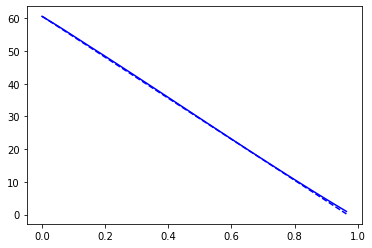

In [275]:
fig=plt.figure()
plt.plot(b1.time_step, objective(b1.time_step, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6], popt[7]), 'b')
plt.plot(b1.time_step,b1.u_in,'b--')

In [276]:
popt

array([-1.12103113e+00, -2.56622064e+01, -4.67431369e+06,  2.15366890e+07,
        7.24561473e+01,  8.78820322e-01,  5.30036124e+01,  3.20638456e+01])

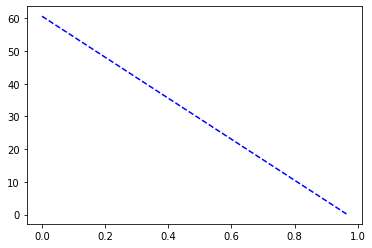

In [269]:
fig=plt.figure()
#plt.plot(b1.time_step, objective(b1.time_step, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6], popt[7]), 'b')
plt.plot(b1.time_step,b1.u_in,'b--')

In [263]:
def objective(x,a,b,c,d,e,f,g,h):
    return a*np.exp(b*x)*np.sin(c*x+d) + e*np.sin(f*x+g) + h


# create empty df for appending
df_test=df[['u_in', 'time_step', 'breath_id']]
bad_list = []
best_list = []
array_sub=df_test.breath_id.unique()

param_grid=[]
param_grid.append([ 12.752477  ,  -0.67085112, 5.41190447,  -0.48596679, 3.86219028, -10.43610426,   8.54696684,  26.1692981 ])
param_grid.append([1., 1., 1., 1., 1., 1., 1., 1.])
param_grid.append([ 1.58058048e+02, -1.18886829e+02,  6.01874280e+00, -4.40444318e-02, 1.76085019e+03,  5.31506372e-02,  7.84477603e+00, -1.75345221e+03])
param_grid.append([ 7.45420090e+01, -4.17773867e+00,  5.14196774e-04,  3.92699079e+01, 7.99735712e+00, -4.17788453e+02,  5.35821023e+01,  1.43435984e+01])
param_grid.append([-2.25719774e+02, -7.45066743e+00,  1.38131154e+00,  5.45286414e+04, -7.13305976e-01, -5.13440990e+02,  7.16388533e+01,  4.88938101e+00])
param_grid.append([  42.62237091,  -16.26589619,  -14.89248189,   35.13124029, 7.5846033 , -409.21910021,   56.0709293 ,   31.10053304])
param_grid.append([-7.69457408e+01,  3.55148343e+00, -1.07325601e-04,  4.08297529e+01, 1.20378611e+00, -4.13966853e+02,  5.47407122e+01,  2.41457554e+01])

for i in tqdm(range(len(array_sub))):
    counter=0
    bmae=1000
    breath = df_test[df_test['breath_id']==array_sub[i]][['time_step', 'u_in']]
    
    for p_set in param_grid:
        try:
            popt, pcov = curve_fit(objective, breath.time_step, breath.u_in, p0=p_set, maxfev=5000)
            bestp=popt
            break
            #new_mae = np.sum(np.abs(objective(breath.time_step, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6], popt[7])-breath.u_in))/(breath.shape[0])
            #if new_mae<bmae:
            #    bmae=new_mae
            #    bestp=popt

        except Exception:
            counter+=1
    
    if counter==len(param_grid):
        bad_list.append(array_sub[i])
    else:
        best_list.append(bestp)

100%|██████████| 75450/75450 [25:56:20<00:00,  1.24s/it]     


In [261]:
best_list

[array([ 6.92236529e+01, -4.28445525e+01, -8.68846986e-04, -3.26946231e-01,
         6.09549324e+00, -4.28865547e+00,  2.97641376e+00,  2.13714947e+01]),
 array([ 1.19692174e+00, -4.54530483e+00,  7.10333846e+01, -1.63538511e+00,
         5.89197221e+03,  4.16265837e-02,  4.65981678e+00,  5.89725333e+03]),
 array([16.26325238, -9.42237214, 17.93175182, -1.32695539,  6.16619387,
         2.22783989,  2.58223503, 12.51283169])]

In [264]:
len(bad_list)

1

In [266]:
bad_list

[69451]

In [280]:
array_sub=df_test.breath_id.unique()

a1list = []
b1list = []
c1list = []
d1list = []
e1list = []
f1list = []
g1list = []
h1list = []
mae1list = []

counter=0
for i in tqdm(range(len(array_sub))):
    breath = df_test[df_test['breath_id']==array_sub[i]][['time_step', 'u_in']]
    
    if array_sub[i]==69451:
        bparams=[-1.12103113e+00, -2.56622064e+01, -4.67431369e+06,  2.15366890e+07, 7.24561473e+01,  8.78820322e-01,  5.30036124e+01,  3.20638456e+01]
        mae= mean_absolute_error(objective(breath.time_step, bparams[0], bparams[1], bparams[2], bparams[3], bparams[4], bparams[5], bparams[6], bparams[7]),breath.u_in)
        a1list += [-1.12103113e+00]*80
        b1list += [-2.56622064e+01]*80
        c1list += [-4.67431369e+06]*80
        d1list += [2.15366890e+07]*80
        e1list += [7.24561473e+01]*80
        f1list += [8.78820322e-01]*80
        g1list += [5.30036124e+01]*80
        h1list += [3.20638456e+01]*80
        mae1list += [mae]*80
        counter=1
    else:
        bparams=best_list[i-counter]
        mae= mean_absolute_error(objective(breath.time_step, bparams[0], bparams[1], bparams[2], bparams[3], bparams[4], bparams[5], bparams[6], bparams[7]),breath.u_in)
        a1list += [bparams[0]]*80
        b1list += [bparams[1]]*80
        c1list += [bparams[2]]*80
        d1list += [bparams[3]]*80
        e1list += [bparams[4]]*80
        f1list += [bparams[5]]*80
        g1list += [bparams[6]]*80
        h1list += [bparams[7]]*80
        mae1list += [mae]*80

100%|██████████| 75450/75450 [03:40<00:00, 342.82it/s]


In [52]:
df2 = pd.read_csv('data/train.csv')
#df2 = df2[['id', 'u_in', 'breath_id']]
feats2=pd.read_csv('allfeatsv2.csv')
df2 = df2.merge(feats2, on='id')

In [76]:
df2.head()

,id,breath_id,R,C,time_step_x,u_in,u_out,pressure,a1,b1,...,time_step_y,rtime,u_in_cumsum,exponent,factor,vf,vt,v,step_id,time_step
0,1,1,20,50,0.000000,0.083334,0,5.837492,69.223653,-42.844553,...,0.000000,0.000,0.083334,-0.000000,1.000000,1.666680,0,1.666680,1,0.000000
1,2,1,20,50,0.033652,18.383041,0,5.907794,69.223653,-42.844553,...,0.033652,0.034,18.466375,-0.000034,0.999966,369.339938,0,369.339938,2,0.033652
2,3,1,20,50,0.067514,22.509278,0,7.876254,69.223653,-42.844553,...,0.067514,0.068,40.975653,-0.000068,0.999932,819.568396,0,819.568396,3,0.067514
3,4,1,20,50,0.101542,22.808822,0,11.742872,69.223653,-42.844553,...,0.101542,0.102,63.784476,-0.000102,0.999898,1275.819053,0,1275.819053,4,0.101542
4,5,1,20,50,0.135756,25.355850,0,12.234987,69.223653,-42.844553,...,0.135756,0.136,89.140326,-0.000136,0.999864,1783.048558,0,1783.048558,5,0.135756


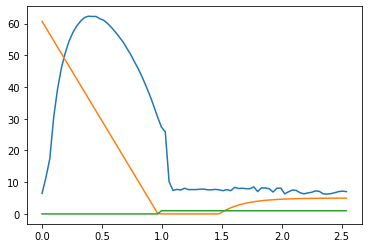

In [78]:
bad_breath=df2.query('breath_id==69451')
fig=plt.figure()
plt.plot(bad_breath.time_step, bad_breath.pressure)
plt.plot(bad_breath.time_step, bad_breath.u_in)
plt.plot(bad_breath.time_step, bad_breath.u_out)

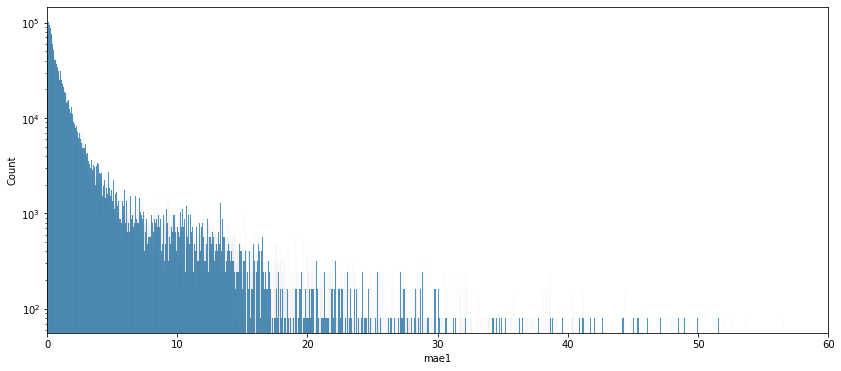

In [289]:
fig=plt.figure(figsize=(14,6))
sns.histplot(df2.mae1)
plt.xlim(0,60)
plt.yscale('log')

In [12]:
df2.isna()

,id,breath_id,R,C,time_step_x,u_in,u_out,pressure,a1,b1,...,vol,time_step_y,rtime,u_in_cumsum,exponent,factor,vf,vt,v,step_id
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
6035996,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
6035997,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
6035998,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False


In [56]:
df2[df2.isnull().any(axis=1)]

,id,breath_id,R,C,time_step_x,u_in,u_out,pressure,a1,b1,...,vol,time_step_y,rtime,u_in_cumsum,exponent,factor,vf,vt,v,step_id


In [54]:
df2['vol'] = df['time_step'] * df['u_in']
df2.query('u_out==0')['vol'] = df2.query('u_out==0').groupby('breath_id')['vol'].cumsum()
df2.query('u_out==1')['vol'] = df2.query('u_out==0').groupby('breath_id')['vol'].max()
df2['u_in_cumsum'] = (df2['u_in']).groupby(df2['breath_id']).cumsum()
df2['vf']=(df2['u_in_cumsum']*df2['R'])/df2['factor']
df2['vt']=0
df2['v']=df2['vf']+df2['vt']

/var/folders/fx/jr2m6h953_103f1b248p3r6h0000gn/T/ipykernel_32028/1063134689.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.query('u_out==0')['vol'] = df2.query('u_out==0').groupby('breath_id')['vol'].cumsum()
/var/folders/fx/jr2m6h953_103f1b248p3r6h0000gn/T/ipykernel_32028/1063134689.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.query('u_out==1')['vol'] = df2.query('u_out==0').groupby('breath_id')['vol'].max()


In [65]:
df2['time_step'] = df3.time_step

In [67]:
new_vol=[]
for b_id in df2.breath_id.unique():
    breath=df2[df2['breath_id']==b_id]
    #print(df2.columns)
    vol_arr1 = breath.query('u_out==0').time_step * breath.query('u_out==0').u_in
    vol_arr2 = vol_arr1.cumsum()
    new_vol += list(vol_arr2.to_numpy())
    new_vol += [max(list(vol_arr2))]*(80-len(vol_arr2.to_numpy()))


In [69]:
new_vol[25:35]

[254.87492522634864,
 270.09996625648284,
 285.1969508856488,
 300.21025479041714,
 314.9550129597609,
 314.9550129597609,
 314.9550129597609,
 314.9550129597609,
 314.9550129597609,
 314.9550129597609]

In [70]:
df2['vol']=new_vol

In [72]:
df2.columns

Index(['id', 'breath_id', 'R', 'C', 'time_step_x', 'u_in', 'u_out', 'pressure',
       'a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 'h1', 'mae1', 'utm1', 'utm2',
       'utm3', 'asc', 'std', 'mean', 'vol', 'time_step_y', 'rtime',
       'u_in_cumsum', 'exponent', 'factor', 'vf', 'vt', 'v', 'step_id',
       'time_step'],
      dtype='object')

In [32]:
df2.time_step_y.head()

0    0.000000
1    0.033652
2    0.067514
3    0.101542
4    0.135756
Name: time_step_y, dtype: float64

In [58]:
df2.columns

Index(['id', 'breath_id', 'R', 'C', 'time_step_x', 'u_in', 'u_out', 'pressure',
       'a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 'h1', 'mae1', 'utm1', 'utm2',
       'utm3', 'asc', 'std', 'mean', 'vol', 'time_step_y', 'rtime',
       'u_in_cumsum', 'exponent', 'factor', 'vf', 'vt', 'v', 'step_id'],
      dtype='object')

In [73]:
savedf = df2.drop(['breath_id', 'R', 'C', 'pressure', 'u_in', 'u_out', 'time_step_x', 'time_step_y', 'time_step'], axis=1)

In [74]:
savedf.columns

Index(['id', 'a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 'h1', 'mae1', 'utm1',
       'utm2', 'utm3', 'asc', 'std', 'mean', 'vol', 'rtime', 'u_in_cumsum',
       'exponent', 'factor', 'vf', 'vt', 'v', 'step_id'],
      dtype='object')

In [75]:
savedf.to_csv('all_featsv3.csv', index=False)

In [50]:
df3 = pd.read_csv('data/train.csv')
#df2 = df2[['id', 'u_in', 'breath_id']]
allfeats=pd.read_csv('all_featsv1.csv')
df3 = df3.merge(allfeats, on='id')

In [51]:
df3.columns

Index(['id', 'breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure',
       'a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 'h1', 'mae1', 'utm1', 'utm2',
       'utm3', 'asc', 'std', 'mean', 'vol', 'rtime', 'u_in_cumsum', 'exponent',
       'factor', 'vf', 'vt', 'v', 'step_id'],
      dtype='object')

In [ ]:
df3 = df3.drop()

In [48]:
linreg=LinearRegression()
linreg.fit(df3.query('u_out==0').drop('pressure',axis=1), df3.query('u_out==0').pressure)

LinearRegression()

In [44]:
linreg.predict(df3.query('u_out==0').drop('pressure',axis=1))

array([ 6.64184732,  5.39314525,  6.28377147, ..., 23.43824017,
       23.46780009, 23.63850639])

In [49]:
mean_absolute_error(linreg.predict(df3.query('u_out==0').drop('pressure',axis=1)), df3.query('u_out==0').pressure)

3.675515000699156

In [47]:
df3.query('u_out==1').vol = 0

/var/folders/fx/jr2m6h953_103f1b248p3r6h0000gn/T/ipykernel_32028/2952411960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.query('u_out==1').vol = 0


/var/folders/fx/jr2m6h953_103f1b248p3r6h0000gn/T/ipykernel_32028/2066872310.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0', '2000', '4000', '6000', '8000', '10000', '12000'], fontsize=16)


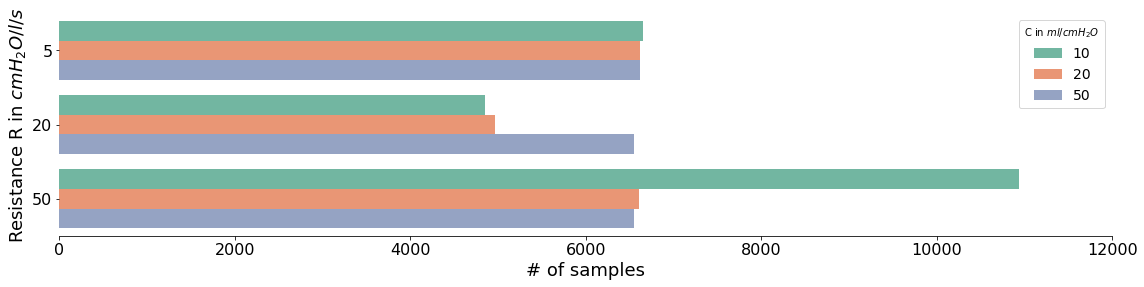

In [136]:
fig=plt.figure(figsize=(16,4))
ax=sns.countplot(data=df2, y='R', hue='C', palette='Set2')
#ax.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1.0', '1.2'], fontsize=14)

ax.set_xticklabels(['0', '2000', '4000', '6000', '8000', '10000', '12000'], fontsize=16)
ax.set_yticklabels(['5', '20', '50'], fontsize=16)
ax.set_ylabel(r'Resistance R in $cmH_2O/l/s$', fontsize=18)
ax.set_xlabel(r'# of samples', fontsize=18)
plt.xlim(0,1200000)
#ax.set_title(r'Number of samples by Resistance and Compliance', fontsize=18)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.ylim(0,1200000)
ax.legend(title=r'C in $ml/cmH_2O$', fontsize=14)
plt.tight_layout()
plt.savefig('countvert.png', transparent=True)

In [100]:
df2['bstepid']=df2.id.apply(lambda x: x%80)

/var/folders/fx/jr2m6h953_103f1b248p3r6h0000gn/T/ipykernel_32028/2146316776.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35'], fontsize=14)


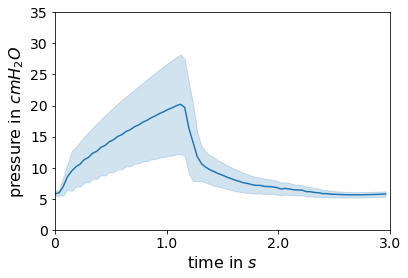

In [115]:
ax=sns.lineplot(data=df2.query('C==50 & R==5'), x='bstepid', y='pressure', ci='sd')
plt.ylim(0,35)
plt.xlim(0,80)
plt.xticks([0, 80/3, 80/3*2, 80])
ax.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35'], fontsize=14)
ax.set_xticklabels(['0', '1.0', '2.0', '3.0'], fontsize=14)
ax.set_xlabel(r'time in $s$', fontsize=16)
ax.set_ylabel(r'pressure in $cmH_2O$', fontsize=16);

/var/folders/fx/jr2m6h953_103f1b248p3r6h0000gn/T/ipykernel_32028/4033320514.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35'], fontsize=14)


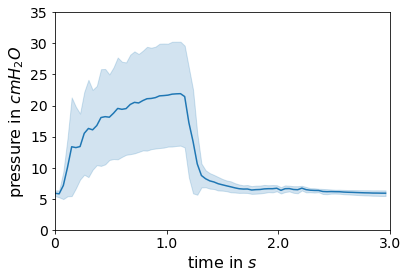

In [114]:
ax=sns.lineplot(data=df2.query('C==20 & R==20'), x='bstepid', y='pressure', ci='sd')
plt.ylim(0,35)
plt.xlim(0,80)
plt.xticks([0, 80/3, 80/3*2, 80])
ax.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35'], fontsize=14)
ax.set_xticklabels(['0', '1.0', '2.0', '3.0'], fontsize=14)
ax.set_xlabel(r'time in $s$', fontsize=16)
ax.set_ylabel(r'pressure in $cmH_2O$', fontsize=16);

/var/folders/fx/jr2m6h953_103f1b248p3r6h0000gn/T/ipykernel_32028/4258415805.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35'], fontsize=14)


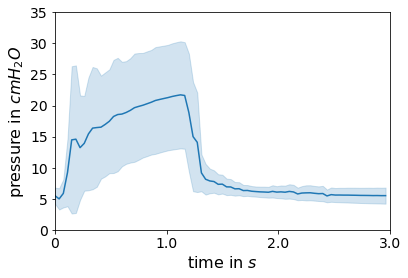

In [116]:
ax=sns.lineplot(data=df2.query('C==10 & R==50'), x='bstepid', y='pressure', ci='sd')
plt.ylim(0,35)
plt.xlim(0,80)
plt.xticks([0, 80/3, 80/3*2, 80])
ax.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35'], fontsize=14)
ax.set_xticklabels(['0', '1.0', '2.0', '3.0'], fontsize=14)
ax.set_xlabel(r'time in $s$', fontsize=16)
ax.set_ylabel(r'pressure in $cmH_2O$', fontsize=16);

In [ ]:
pred_imp = []
for val in y_pred:
    if val>100.:
        pred_imp.append(100.)
    elif val<0.:
        pred_imp.append(0.)
    else:
        pred_imp.append(val)

plots with shared axis

/var/folders/fx/jr2m6h953_103f1b248p3r6h0000gn/T/ipykernel_32028/1428575350.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35'], fontsize=16)


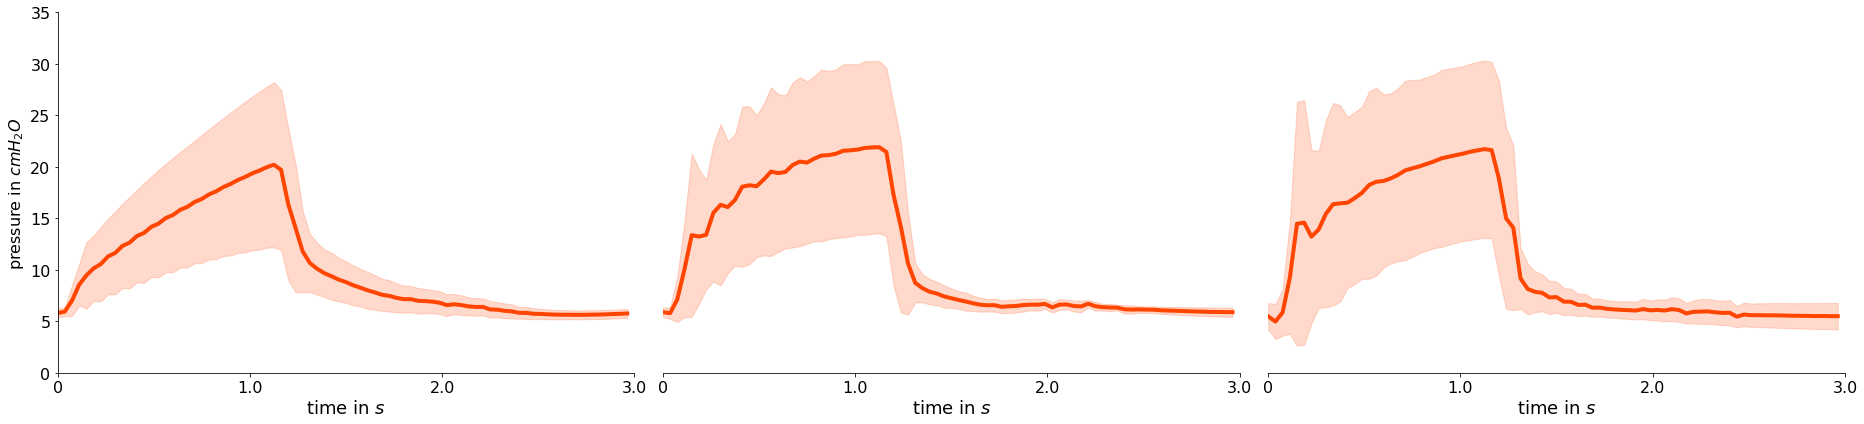

In [158]:
tick_fsize=

linecol='orangered'

fig=plt.figure(figsize=(26,6))
ax1 = plt.subplot(131)
sns.lineplot(data=df2.query('C==50 & R==5'), x='bstepid', y='pressure', ci='sd', color=linecol, linewidth=4.0)
plt.ylim(0,35)
plt.xlim(0,80)

ax1.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2 = plt.subplot(132, sharey=ax1, sharex=ax1)
sns.lineplot(data=df2.query('C==20 & R==20'), x='bstepid', y='pressure', ci='sd', color=linecol, linewidth=4.0)
#plt.axis('off')
ax1.set_ylabel(r'pressure in $cmH_2O$', fontsize=16)
plt.xticks([0, 80/3, 80/3*2, 80])
ax1.set_xticklabels(['0', '1.0', '2.0', '3.0'], fontsize=16)
ax1.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35'], fontsize=16)
ax1.set_xlabel(r'time in $s$', fontsize=18);

ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.xticks([0, 80/3, 80/3*2, 80])
ax2.set_xticklabels(['0', '1.0', '2.0', '3.0'], fontsize=16)
ax2.set_xlabel(r'time in $s$', fontsize=18)

ax3 = plt.subplot(133, sharey=ax1, sharex=ax1)
sns.lineplot(data=df2.query('C==10 & R==50'), x='bstepid', y='pressure', ci='sd', color=linecol, linewidth=4.0)
ax3.get_yaxis().set_visible(False)

ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)

plt.xticks([0, 80/3, 80/3*2, 80])
ax3.set_xticklabels(['0', '1.0', '2.0', '3.0'], fontsize=16)
ax3.set_xlabel(r'time in $s$', fontsize=18)

plt.tight_layout()
plt.savefig('threeshapes.png', transparent=True)